In [1]:
import nbsetup
import ensemblepy as ep
import pandas as pd
import seaborn as sns
import numpy as np
import pickle

In [2]:
df = pd.read_csv("../../datasets/rotten_tomatoes_movies.csv")

In [3]:
df['year'] = pd.to_datetime(df['original_release_date']).dt.year

In [17]:
def single(SPAN = 5):
    years = df['year'].unique()
    years = years[~np.isnan(years)]
    year_range = list(range(1920, int(years.max())+1, SPAN))
    # get rating_difference by year, grouped by content_rating
    year_ensembles = {}
    for year in year_range:
        try:
            yr = int(year)
        # clear NaN values
        except ValueError:
            pass
        else:
            year_data = []
            for c in ('NR', 'PG', 'PG-13', 'R'):
                filtered = df.query('year >=%s & year<%s+%s & content_rating=="%s"' % (year,year,SPAN,c))
                year_data.append(
                    #[filtered.query("audience_status=='Spilled'").count()['year'],
                    # filtered.query("audience_status=='Upright'").count()['year'],
                    # filtered.query("tomatometer_status=='Rotten'").count()['year'],
                    # filtered.query("tomatometer_status=='Certified-Fresh'").count()['year'],
                    # filtered.query("tomatometer_status=='Fresh'").count()['year'],
                    #])
                     [filtered.query("audience_status=='Spilled'&tomatometer_status=='Rotten'").count()['year'],
                     filtered.query("audience_status=='Spilled'&tomatometer_status=='Certified-Fresh'").count()['year'],
                     filtered.query("audience_status=='Spilled'&tomatometer_status=='Fresh'").count()['year'],
                     filtered.query("audience_status=='Upright'&tomatometer_status=='Rotten'").count()['year'],
                     filtered.query("audience_status=='Upright'&tomatometer_status=='Certified-Fresh'").count()['year'],
                     filtered.query("audience_status=='Upright'&tomatometer_status=='Fresh'").count()['year'],
                    ])
            year_ensembles[yr] = ep.Discrete(year_data, None, histograms=True)
            
    return year_ensembles

In [25]:
data = single(3)

/Users/timjdavey/Projects/complexity/lib/python3.9/site-packages/scipy/stats/_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/Users/timjdavey/Projects/complexity/complexity/notebooks/incoherence/../../ensemblepy/entropy.py:47: RuntimeWarning: invalid value encountered in true_divide
  normed = np.array([row / row.sum() for row in np.array(pmfs)])
/Users/timjdavey/Projects/complexity/complexity/notebooks/incoherence/../../ensemblepy/entropy.py:30: RuntimeWarning: invalid value encountered in true_divide
  return ws / ws.sum()
/Users/timjdavey/Projects/complexity/lib/python3.9/site-packages/scipy/stats/_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/Users/timjdavey/Projects/complexity/complexity/notebooks/incoherence/../../ensemblepy/entropy.py:47: RuntimeWarning: invalid value encountered in true_divide
  normed = np.array([row / ro

[(0.0, 0.22)]

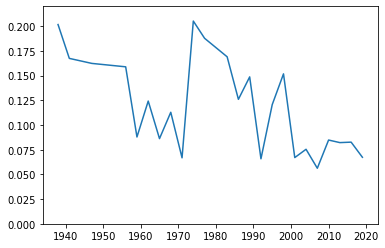

In [36]:
sns.lineplot(x=data.keys(), y=[v.incoherence for v in data.values()]).set(ylim=(0,0.22))

<AxesSubplot:>

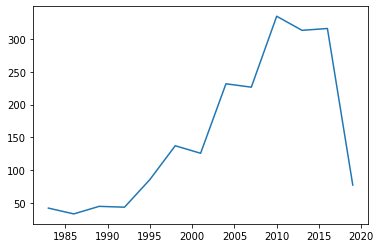

In [37]:
sns.lineplot(x=data.keys(), y=[v.comparison()['chi2'] for v in data.values()])

<AxesSubplot:>

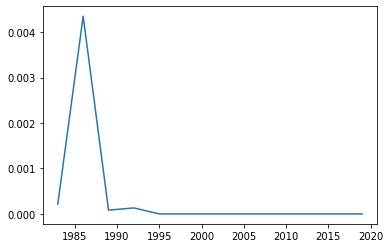

In [38]:
sns.lineplot(x=data.keys(), y=[v.comparison()['chi2 p'] for v in data.values()])

In [45]:
df['rating_difference']=df['tomatometer_rating']-df['audience_rating']

In [5]:
df.columns

Index(['rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'rating_difference', 'year'],
      dtype='object')

In [92]:
def ensembles(MEASURE = 'tomatometer_rating', SPAN = 5, norm=(0,100)):
    years = df['year'].unique()
    years = years[~np.isnan(years)]
    year_range = list(range(1920, int(years.max())+1, SPAN))
    # get rating_difference by year, grouped by content_rating
    year_ensembles = {}
    for year in year_range:
        try:
            yr = int(year)
        # clear NaN values
        except ValueError:
            pass
        else:
            year_data = []
            for c in ('NR', 'PG', 'PG-13', 'R'):
                year_data.append(df.query('year >=%s & year<%s+%s  & content_rating=="%s"' % (year,year,SPAN,c))[MEASURE].to_list())
            try:
                e = ep.Continuous(year_data, norm)
                nbsetup.cp(yr, e.incoherence)
                year_ensembles[year] = e
            except ValueError:
                pass
    return year_ensembles

In [104]:
def plot(conts):
    x = conts.keys()
    g = sns.lineplot(x=x, y=[v.incoherence for v in conts.values()], label='incoherence', color='black')
    g.set(ylim=(0,0.25))
    twin = g.twinx()
    sns.lineplot(x=x, y=[v.comparison()['Kruskal p'] for v in conts.values()], label='Kruskal').set(ylim=(0,1))
    sns.lineplot(x=x, y=[v.comparison()['ANOVA p'] for v in conts.values()], label='ANOVA').set(ylim=(0,1))
    g.axhline(0.07, color='grey', linestyle='dotted')

In [117]:
span = 5

2020 0.046741715788192265


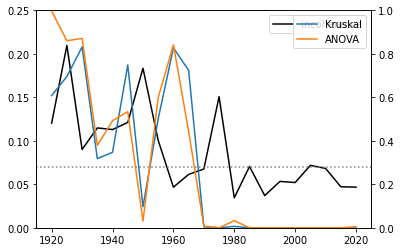

In [118]:
plot(ensembles(SPAN=span))

2020 0.06835066428903802


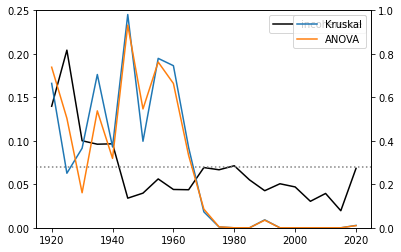

In [119]:
plot(ensembles('audience_rating', span))

2020 0.029003285755759323


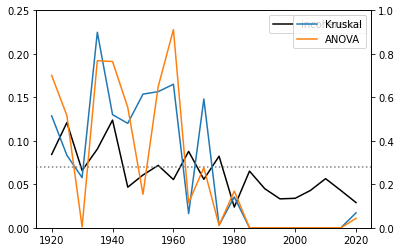

In [120]:
plot(ensembles('rating_difference', span, norm=(-100,100)))

In [56]:
df.genres.unique()

array(['Action & Adventure, Comedy, Drama, Science Fiction & Fantasy',
       'Comedy', 'Comedy, Romance', ...,
       'Animation, Art House & International, Drama, Science Fiction & Fantasy, Romance',
       'Art House & International, Romance',
       'Action & Adventure, Drama, Horror, Kids & Family, Mystery & Suspense'],
      dtype=object)

In [61]:
llist = []
for g in df.genres.unique():
    for i in str(g).split(','):
        llist.append(str(i).strip())
unique_genres = set(llist)

In [63]:
for g in unique_genres:
    df[g] = df.genres.str.contains(g)

In [72]:
production_50 = df.groupby('production_company').count().query('rotten_tomatoes_link > 50').index.to_list()
production_100 = df.groupby('production_company').count().query('rotten_tomatoes_link > 100').index.to_list()

In [329]:
prods = {}
discrete = True
for p in production_50:
    obs = []
    labels = []
    if not discrete:
        for g in unique_genres:
            films = df[df['production_company']==p][df[g].fillna(False)]['audience_rating'].dropna().to_list()
            if len(films) > 10: #and len(obs) < 5:
                obs.append(films)
                labels.append(g)
        prods[p] = ep.Continuous(obs, (0,100), labels=labels)
    else:
        for g in unique_genres:
            filtered = df[df['production_company']==p][df[g].fillna(False)]
            films = [filtered.query("audience_status=='Spilled'").count()['year'],
                     filtered.query("audience_status=='Upright'").count()['year']]
            if sum(films) > 20:
                obs.append(films)
                labels.append(g)
        if len(obs) > 1:
            prods[p] = ep.Discrete(obs, None, labels=labels, histograms=True)

<ipython-input-329-4c313226e352>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered = df[df['production_company']==p][df[g].fillna(False)]


20th Century Fox [[57, 123], [49, 45], [95, 75], [39, 42], [14, 13], [11, 46], [11, 16], [72, 81], [15, 34], [33, 34]]
Anchor Bay Entertainment [[26, 9], [18, 5], [26, 9], [29, 7], [18, 9]]
Buena Vista [[10, 23], [26, 24], [17, 18], [20, 18]]
Buena Vista Pictures [[16, 29], [7, 14], [33, 19], [14, 21], [19, 26]]
Cohen Media Group [[10, 12], [24, 20]]
Columbia Pictures [[35, 92], [22, 17], [54, 50], [22, 25], [11, 40], [36, 33], [13, 24], [10, 11]]
Criterion Collection [[6, 61], [5, 92], [1, 22], [1, 35]]
Film Movement [[12, 28], [18, 46]]
First Run Features [[7, 14], [18, 64], [11, 57]]
Focus Features [[33, 64], [18, 28], [15, 18], [9, 12]]
Fox [[11, 30], [10, 27]]
Fox Searchlight [[8, 32], [11, 17]]
Fox Searchlight Pictures [[12, 42], [14, 21]]
Gravitas Ventures [[22, 16], [5, 18], [22, 10]]
HBO Video [[22, 23], [15, 10], [14, 10], [15, 7]]
IFC Films [[32, 58], [140, 119], [13, 48], [74, 55], [65, 24], [43, 4], [20, 16], [10, 33]]
Independent Pictures [[14, 15], [7, 19]]
Kino Lorber [

In [343]:
if discrete:
    consoled = []
    for k, v in prods.items():
        pool = np.concatenate(v.observations)
        comp = v.comparison()
        consoled.append({
            'company': k,
            'incoherence': v.incoherence,
            'mean percent': np.mean([h[0]/sum(h) for h in v.histograms]),
            'chi2 p': comp['chi2 p'],
            'genres': len(v.histograms),
        })
    
    analysis = pd.DataFrame(data=consoled)
else:
    consoled = []
    for k, v in prods.items():
        pool = np.concatenate(v.observations)
        comp = v.comparison()
        consoled.append({
            'company': k,
            'incoherence': v.incoherence,
            'mean': pool.mean(),
            'std': pool.std(),
            'Kruskal': comp['Kruskal'],
            'ANOVA': comp['ANOVA'],
            'genres': len(v.observations),
        })
    
    analysis = pd.DataFrame(data=consoled)

<AxesSubplot:>

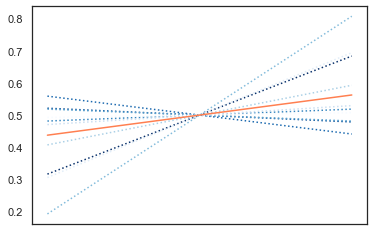

In [348]:
ep.plot_discrete(prods['20th Century Fox'])

<AxesSubplot:>

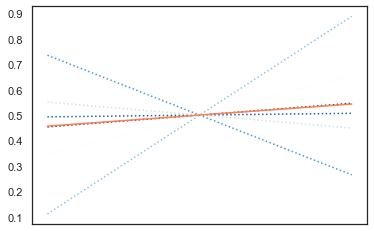

In [349]:
ep.plot_discrete(prods['Twentieth Century Fox Home Entertainment'])

In [347]:
analysis.sort_values('chi2 p')

,company,incoherence,mean percent,chi2 p,genres
15,IFC Films,0.148894,0.514525,1.667121e-17,8
24,Magnolia Pictures,0.143734,0.485514,5.040469e-13,9
39,Sony Pictures Home Entertainment,0.080411,0.524335,5.085348e-11,10
52,Warner Home Video,0.076342,0.459259,2.620486e-10,9
22,MGM,0.098882,0.447599,5.467019e-09,10
46,Universal Pictures,0.097110,0.418048,3.629740e-08,10
32,Paramount Pictures,0.073505,0.410202,2.649157e-07,10
23,MGM Home Entertainment,0.129751,0.290591,6.943985e-07,7
28,Netflix,0.188616,0.505403,1.513433e-06,4
0,20th Century Fox,0.070595,0.426640,1.553943e-06,10


In [301]:
consoled = []
for k, v in prods.items():
    pool = np.concatenate(v.observations)
    comp = v.comparison()
    consoled.append({
        'company': k,
        'incoherence': v.incoherence,
        'mean': pool.mean(),
        'std': pool.std(),
        'Kruskal': comp['Kruskal'],
        'ANOVA': comp['ANOVA'],
        'genres': len(v.observations),
    })

analysis = pd.DataFrame(data=consoled)

<AxesSubplot:xlabel='company', ylabel='mean'>

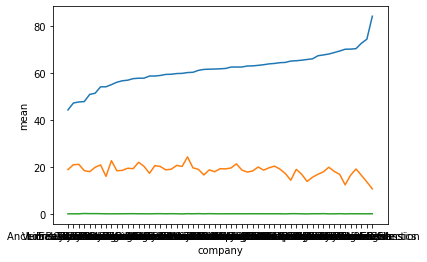

In [174]:
sort = analysis.sort_values('mean')
sns.lineplot(data=sort, x='company', y='mean')
sns.lineplot(data=sort, x='company', y='std')
sns.lineplot(data=sort, x='company', y='incoherence')

In [222]:
def genre_data(p):
    data = []
    for i, vs in enumerate(p.observations):
        for v in vs:
            data.append({
                'genre': p.labels[i],
                'value': v
            })
    return pd.DataFrame(data)

In [223]:
def swarm(p):
    ax = sns.swarmplot(data=genre_data(p), y='value', x='genre')
    ax.set(ylim=(0,100))

In [272]:
def ridge(name):
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    p = prods[name]
    df = genre_data(p)
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df, row="genre", hue="genre", aspect=15, height=.5, palette=pal)
    g.map(sns.kdeplot, "value",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw_adjust=.5)
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
    g.figure.subplots_adjust(hspace=-.25)
    g.set_titles("")
    g.set(yticks=[], ylabel="", xlim=(0,100))
    g.despine(bottom=True, left=True)
    print("%s, i=%.2f, a=%.8f" % (name, p.incoherence, p.comparison()['ANOVA']))

Film Movement, i=0.02, a=0.35459621


/Users/timjdavey/Projects/complexity/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
/Users/timjdavey/Projects/complexity/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


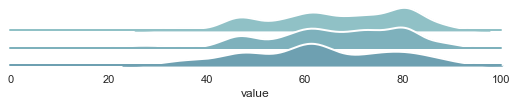

In [273]:
ridge('Film Movement')

/Users/timjdavey/Projects/complexity/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
/Users/timjdavey/Projects/complexity/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


MGM, i=0.08, a=7.77142467


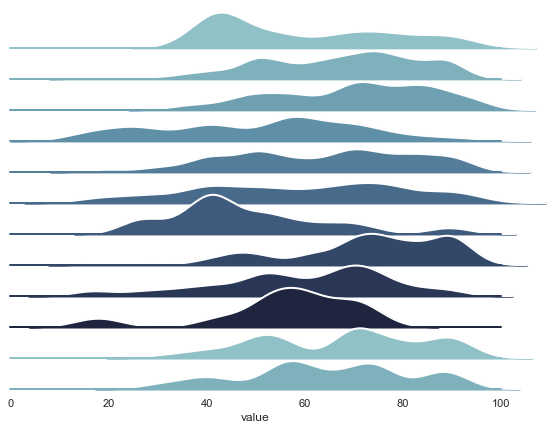

In [274]:
ridge('MGM')

/Users/timjdavey/Projects/complexity/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
/Users/timjdavey/Projects/complexity/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


Sony Pictures Home Entertainment, i=0.08, a=11.27566544


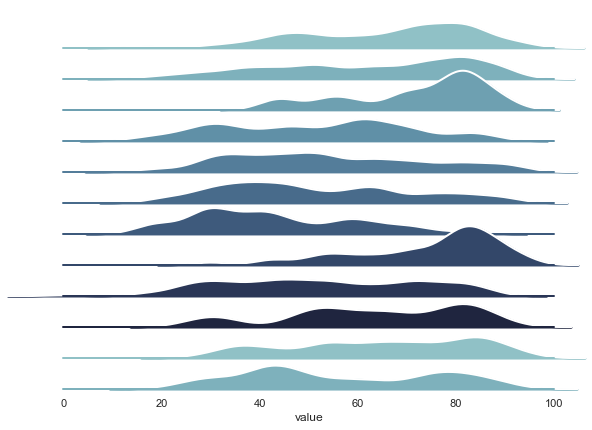

In [278]:
ridge('Sony Pictures Home Entertainment')

/Users/timjdavey/Projects/complexity/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
/Users/timjdavey/Projects/complexity/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


HBO Video, i=0.11, a=1.92156453


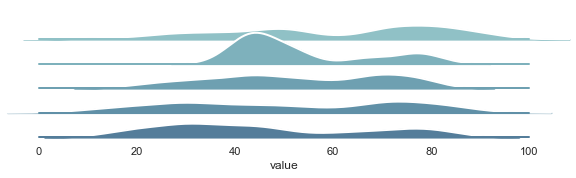

In [292]:
ridge('United Artists')

/Users/timjdavey/Projects/complexity/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
/Users/timjdavey/Projects/complexity/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


LionsGate Entertainment, i=0.13, a=2.08773466


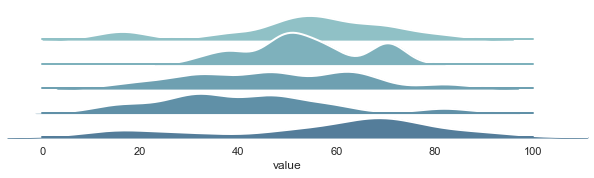

In [296]:
ridge('LionsGate Entertainment')

/Users/timjdavey/Projects/complexity/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
/Users/timjdavey/Projects/complexity/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


Strand Releasing, i=0.06, a=2.07836629


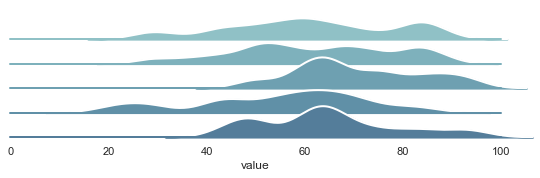

In [297]:
ridge('Strand Releasing')

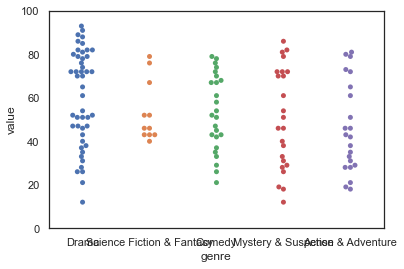

In [319]:
swarm(prods['HBO Video'])

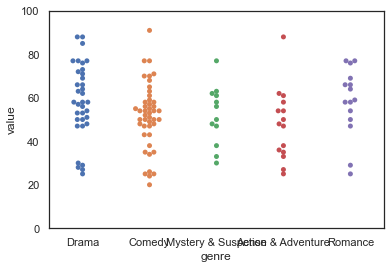

In [320]:
swarm(prods['Touchstone Pictures'])

/Users/timjdavey/Projects/complexity/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
/Users/timjdavey/Projects/complexity/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


HBO Video, i=0.11, a=1.92156453


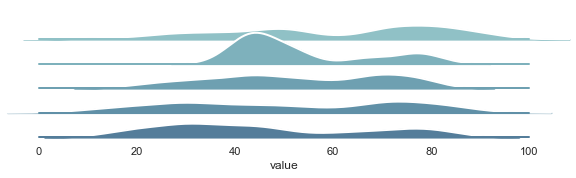

In [317]:
ridge('HBO Video')

/Users/timjdavey/Projects/complexity/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
/Users/timjdavey/Projects/complexity/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


Touchstone Pictures, i=0.07, a=1.92519392


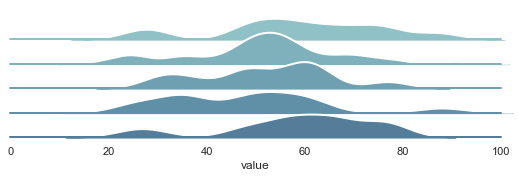

In [318]:
ridge('Touchstone Pictures')

In [307]:
analysis.sort_values('ANOVA')

,company,incoherence,mean,std,Kruskal,ANOVA,genres
29,Music Box Films,0.033527,69.993151,12.374021,0.935066,0.242920,5
7,Film Movement,0.015959,65.639344,13.817941,0.672591,0.354596,3
56,Zeitgeist Films,0.055430,74.270833,13.599540,1.569569,0.436105,4
6,Criterion Collection,0.081155,84.017986,10.676895,3.153117,0.581028,8
18,Kino Lorber,0.114987,64.975000,14.327399,1.609632,0.688863,4
4,Cohen Media Group,0.011626,59.735294,20.200188,1.145154,0.917323,2
52,Walt Disney Pictures,0.039530,67.962145,19.850192,6.015502,0.918508,7
10,Fox,0.080957,67.224000,16.859829,2.198498,0.946469,5
9,Focus Features,0.026057,64.395455,17.166643,4.998576,1.034562,5
36,Saban Films,0.059809,44.195402,18.850189,2.038534,1.131528,3


<AxesSubplot:xlabel='incoherence', ylabel='mean'>

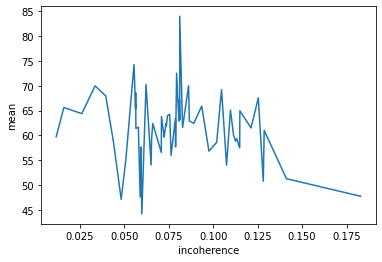

In [191]:
sns.lineplot(data=analysis, x='incoherence', y='mean')

<AxesSubplot:xlabel='incoherence', ylabel='std'>

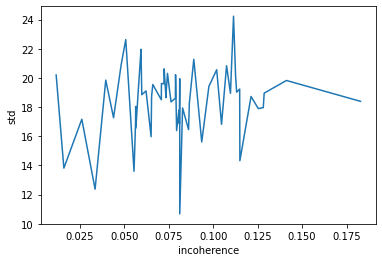

In [192]:
sns.lineplot(data=analysis, x='incoherence', y='std')

<AxesSubplot:xlabel='incoherence', ylabel='ANOVA'>

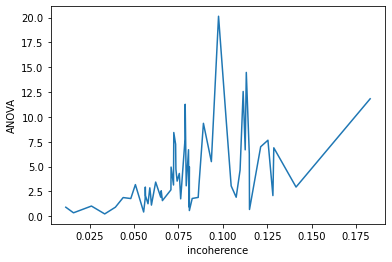

In [193]:
sns.lineplot(data=analysis, x='incoherence', y='ANOVA')

<AxesSubplot:xlabel='incoherence', ylabel='Kruskal'>

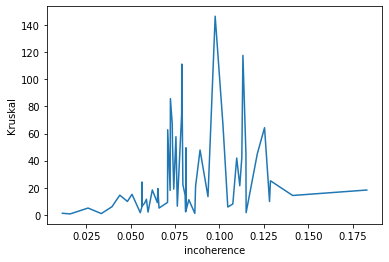

In [194]:
sns.lineplot(data=analysis, x='incoherence', y='Kruskal')